# Proyecto 2 Reconocimiento de Patrones

José Julián Camacho Hernández

Leonardo Guillén Fernández

In [3]:
import os
import cv2
import time
import math
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import display
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, roc_auc_score, roc_curve, f1_score

# MLP

In [23]:
def computeMetrics(y_test, y_pred, training_time):
    n_classes = 4
    acc = accuracy_score(y_test, y_pred)                        # Calcular la exactitud
    f1 = f1_score(y_test, y_pred, average='macro')              # Calcular F1 score
    rec = recall_score(y_test, y_pred, average='macro')         # Calcular el recall
    prec = precision_score(y_test, y_pred, average='macro')     # Calcular la precisión
    
    # Calcular macro AUC
    test_labels_binary = label_binarize(y_test, classes=np.unique(y_test))
    y_pred_one_hot = label_binarize(y_pred, classes=np.unique(y_test))
    n_classes = test_labels_binary.shape[1]
    auc_scores = []
    for i in range(n_classes):
        y_test_i = test_labels_binary[:, i]     
        y_pred_i = y_pred_one_hot[:, i]                 
        auc_i = roc_auc_score(y_test_i, y_pred_i)
        auc_scores.append(auc_i)
    macro_auc = np.mean(auc_scores)

    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    y_pred_bin = np.zeros((len(y_test), n_classes))
    y_pred_bin[np.arange(len(y_test)), y_pred] = 1    
    metrics = {"Accuracy":acc, "Precision":prec, "Recall":rec, "F1 Score":f1, "AUC":macro_auc, "Tiempo de entrenamiento":training_time}
    df = pd.DataFrame(metrics, index = [0])
    display(df)

    # Calcular la curva ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()


## MLP sin feature extractor

In [5]:
#=====  Cargar y aplicar feature extractor a las imágenes  =====#
X = []
y = []

input_folders = ["./testi3/", "./testi4/", "./testi2/", "./testi/"]
#input_folders = ["drive/MyDrive/COVID-19_Radiography_Dataset/COVID/", "drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity/",
#                 "drive/MyDrive/COVID-19_Radiography_Dataset/Normal/", "drive/MyDrive/COVID-19_Radiography_Dataset/Viral_Pneumonia/"]

i = 0
for folder in input_folders:
    input_folder = folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)                                  # Leer la imagen
            cropped_image = image[20:280, 20:280]                           # Recortar los bordes
            gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)    # Pasarla a escala de grises
            image_np = np.array(gray_image).flatten()                       # COnvertirla en array de 1D
            X.append(image_np)
            y.append(i)
    i+=1

np.save("X.npy", X)
np.save("y.npy", y)
#np.save("drive/MyDrive/X.npy", X)
#np.save("drive/MyDrive/y.npy", y)

In [6]:
#=====  Feature Engineering  =====#

try:
    X_charged = np.load("X.npy")
    y_charged = np.load("y.npy")
    #X_charged = np.load("drive/MyDrive/X.npy")
    #y_charged = np.load("drive/MyDrive/y.npy")
except FileNotFoundError:
    print("Error: File not found.")
       
# Convertir las listas a numpy array de tipo uint8
X_np = np.array(X_charged, dtype=np.uint8)
y_np = np.array(y_charged)

# Normalización de los datos
scaler = MinMaxScaler()
scaler.fit(X_np)
scaled_data = scaler.transform(X_np)
X_np = scaled_data

# Dividir los datos en train y test y estratificar
train_X, test_X, train_y, test_y = train_test_split(
    X_np, y_np, test_size=0.2, stratify=y_np, random_state=42)

# Convertir de numpy array a PyTorch tensor
X_train_tensor = torch.from_numpy(train_X).float()
X_test_tensor = torch.from_numpy(test_X).float()
y_train_tensor = torch.from_numpy(train_y).float()
y_test_tensor = torch.from_numpy(test_y).float()

# Convertir a tensores de tipo long
y_train_long_tensor = y_train_tensor.long()         

# Convertir a one hot
y_onehot = F.one_hot(y_train_long_tensor, num_classes=4).float()


In [7]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, activation):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_layers = nn.ModuleList()
        self.num_classes = num_classes
        self.activation = activation
        # Agregar capas ocultas
        for i, hidden_size in enumerate(hidden_sizes):
            if i == 0:
                self.hidden_layers.append(nn.Linear(input_size, hidden_size))
            else:
                self.hidden_layers.append(nn.Linear(hidden_sizes[i-1], hidden_size))
        # Capa de salida
        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)
        
    def forward(self, x):
        out = x
        # Pasar por capas ocultas
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.activation(out)
        # Pasar por capa de salida
        out = self.output_layer(out)
        return out

### Diseño # 1
Capas: [67600, 128, 64, 4] | Función de activación: ReLU | epochs = 100

==========  Entrenando el modelo  ==========

Epoch: 10/100, Loss: 2.3306758403778076
Epoch: 20/100, Loss: 0.817893385887146
Epoch: 30/100, Loss: 0.6210305094718933
Epoch: 40/100, Loss: 0.5240660309791565
Epoch: 50/100, Loss: 0.4442124366760254
Epoch: 60/100, Loss: 0.38193613290786743
Epoch: 70/100, Loss: 0.33049875497817993
Epoch: 80/100, Loss: 0.2854495942592621
Epoch: 90/100, Loss: 0.24607254564762115
Epoch: 100/100, Loss: 0.21133160591125488

==========  Resultados conjunto de prueba  ==========



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.592593,0.569444,0.539583,0.538919,0.702535,10.584102


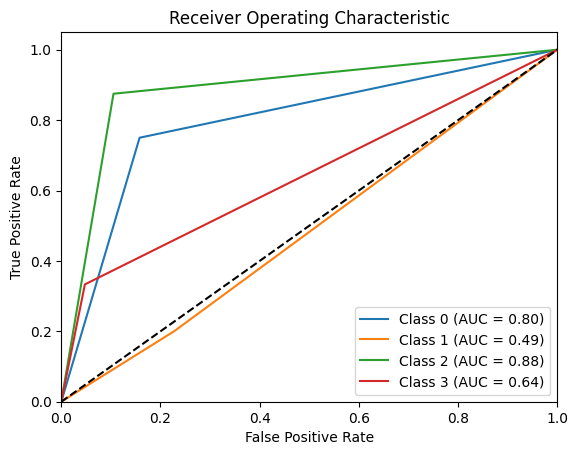

Resultados esperados:  tensor([1., 0., 0., 3., 2., 2., 0., 2.])
Resultados obtenidos:  tensor([0, 1, 0, 3, 2, 2, 0, 2])

==========  Resultados conjunto de entrenamiento  ==========



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.971154,0.977941,0.960526,0.967033,0.975126,10.584102


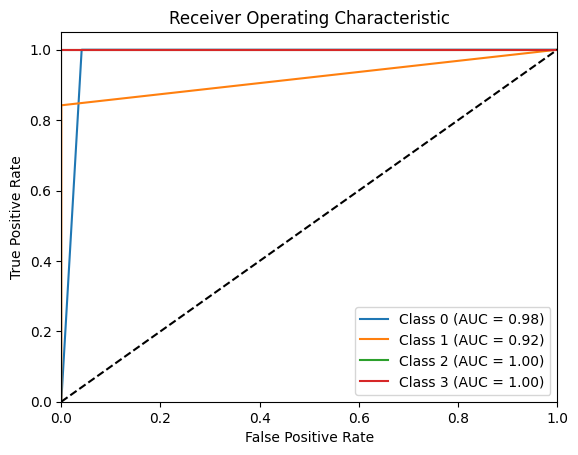

Resultados esperados:  tensor([3., 3., 0., 0., 0., 2., 2., 1.])
Resultados obtenidos:  tensor([3, 3, 0, 0, 0, 2, 2, 0])


In [39]:
#=====  Instaciar modelo  =====#
input_size = X_train_tensor.shape[1]
hidden_sizes = [128, 64]       
num_classes = 4
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation)   

# Definir la función de loss y optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 100
print('|==========  Entrenando el modelo  ==========|\n')
start_time = time.time()
# Entrenar el modelo
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_onehot)
    loss.backward()
    optimizer.step()
    # Imprimir el training loss
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}")
end_time = time.time()
time_taken = end_time - start_time

print('\n|==========  Resultados conjunto de prueba  ==========|\n')
# Evaluar el modelo con el conjunto de testing
outputs = model(X_test_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(y_test_tensor, predicted, time_taken)
print('Resultados esperados: ', y_test_tensor[:8])
print('Resultados obtenidos: ', predicted[:8])

print('\n1==========  Resultados conjunto de entrenamiento  ==========|\n')
# Evaluar el modelo con el conjunto de training
outputs = model(X_train_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(y_train_tensor, predicted, time_taken)
print('Resultados esperados: ', y_train_tensor[:8])
print('Resultados obtenidos: ', predicted[:8])

### Diseño # 2
Capas: [67600, 256, 4] | Función de activación: ReLU | epochs = 100

|==========  Entrenando el modelo  ==========|

Epoch: 10/100, Loss: 7.215834617614746
Epoch: 20/100, Loss: 5.009286880493164
Epoch: 30/100, Loss: 1.9219645261764526
Epoch: 40/100, Loss: 0.8219020366668701
Epoch: 50/100, Loss: 0.5116080045700073
Epoch: 60/100, Loss: 0.34414201974868774
Epoch: 70/100, Loss: 0.30123960971832275
Epoch: 80/100, Loss: 0.260712206363678
Epoch: 90/100, Loss: 0.23030588030815125
Epoch: 100/100, Loss: 0.20654156804084778

|==========  Resultados conjunto de prueba  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.666667,0.719643,0.639583,0.631944,0.76417,20.209377


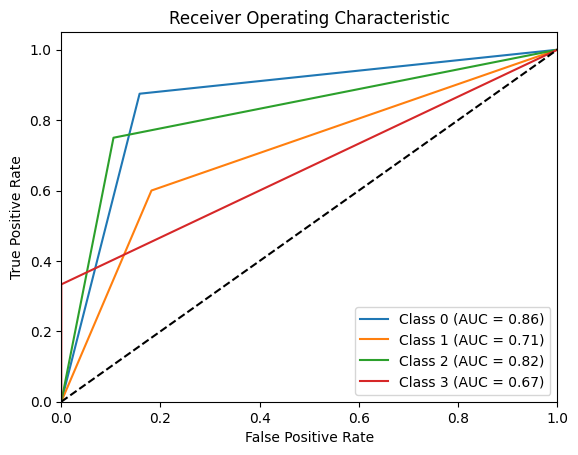

Resultados esperados:  tensor([1., 0., 0., 3., 2., 2., 0., 2.])
Resultados obtenidos:  tensor([0, 1, 0, 3, 2, 2, 0, 2])

|==========  Resultados conjunto de entrenamiento  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.932692,0.930223,0.925777,0.927601,0.951627,20.209377


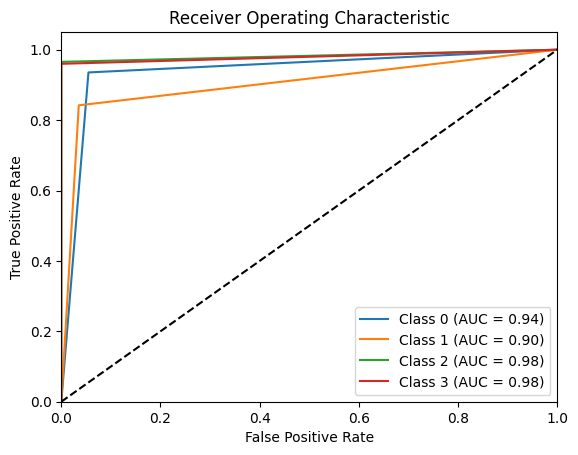

Resultados esperados:  tensor([3., 3., 0., 0., 0., 2., 2., 1.])
Resultados obtenidos:  tensor([3, 3, 0, 0, 0, 2, 2, 1])


In [41]:
#=====  Instaciar modelo  =====#
input_size = X_train_tensor.shape[1]
hidden_sizes = [256]       
num_classes = 4
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation)   

# Definir la función de loss y optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 100
print('|==========  Entrenando el modelo  ==========|\n')
start_time = time.time()
# Entrenar el modelo
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_onehot)
    loss.backward()
    optimizer.step()
    # Imprimir el training loss
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}")
end_time = time.time()
time_taken = end_time - start_time

print('\n|==========  Resultados conjunto de prueba  ==========|\n')
# Evaluar el modelo con el conjunto de testing
outputs = model(X_test_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(y_test_tensor, predicted, time_taken)
print('Resultados esperados: ', y_test_tensor[:8])
print('Resultados obtenidos: ', predicted[:8])

print('\n|==========  Resultados conjunto de entrenamiento  ==========|\n')
# Evaluar el modelo con el conjunto de training
outputs = model(X_train_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(y_train_tensor, predicted, time_taken)
print('Resultados esperados: ', y_train_tensor[:8])
print('Resultados obtenidos: ', predicted[:8])

### Diseño # 3
Capas: [67600, 64, 64, 64, 4] | Función de activación: ReLU | epochs = 100

|==========  Entrenando el modelo  ==========|

Epoch: 10/100, Loss: 1.1549623012542725
Epoch: 20/100, Loss: 0.8891899585723877
Epoch: 30/100, Loss: 0.6982592940330505
Epoch: 40/100, Loss: 0.5480439066886902
Epoch: 50/100, Loss: 0.43112727999687195
Epoch: 60/100, Loss: 0.35141631960868835
Epoch: 70/100, Loss: 0.31679028272628784
Epoch: 80/100, Loss: 0.2288246899843216
Epoch: 90/100, Loss: 0.22169369459152222
Epoch: 100/100, Loss: 0.15664149820804596

|==========  Resultados conjunto de prueba  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.481481,0.505952,0.445833,0.458333,0.636821,5.351233


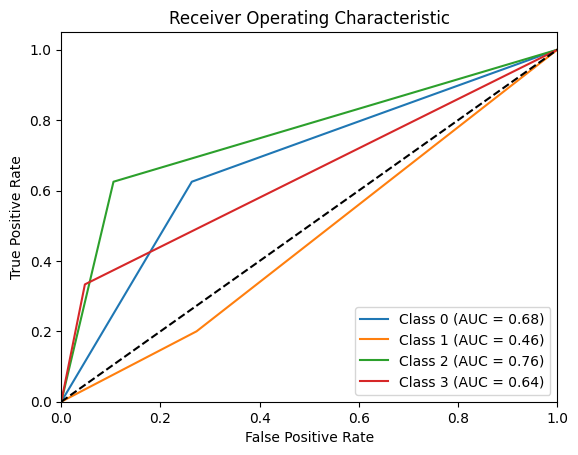

Resultados esperados:  tensor([1., 0., 0., 3., 2., 2., 0., 2.])
Resultados obtenidos:  tensor([0, 1, 0, 3, 2, 2, 0, 2])

1==========  Resultados conjunto de entrenamiento  ==========|



,Accuracy,Precision,Recall,F1 Score,AUC,Tiempo de entrenamiento
0,0.942308,0.942017,0.930127,0.934253,0.955273,5.351233


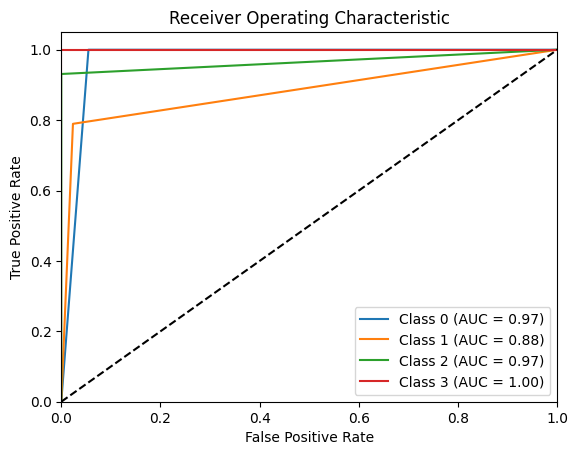

Resultados esperados:  tensor([3., 3., 0., 0., 0., 2., 2., 1.])
Resultados obtenidos:  tensor([3, 3, 0, 0, 0, 1, 2, 0])


In [43]:
#=====  Instaciar modelo  =====#
input_size = X_train_tensor.shape[1]
hidden_sizes = [64, 64, 64]       
num_classes = 4
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation)   

# Definir la función de loss y optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 100
print('|==========  Entrenando el modelo  ==========|\n')
start_time = time.time()
# Entrenar el modelo
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_onehot)
    loss.backward()
    optimizer.step()
    # Imprimir el training loss
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}")
end_time = time.time()
time_taken = end_time - start_time

print('\n|==========  Resultados conjunto de prueba  ==========|\n')
# Evaluar el modelo con el conjunto de testing
outputs = model(X_test_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(y_test_tensor, predicted, time_taken)
print('Resultados esperados: ', y_test_tensor[:8])
print('Resultados obtenidos: ', predicted[:8])

print('\n1==========  Resultados conjunto de entrenamiento  ==========|\n')
# Evaluar el modelo con el conjunto de training
outputs = model(X_train_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(y_train_tensor, predicted, time_taken)
print('Resultados esperados: ', y_train_tensor[:8])
print('Resultados obtenidos: ', predicted[:8])

## MLP con feature extractor LBP

In [44]:
#=====  Feature Extractor  =====#
def lbp(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp_image = np.zeros_like(gray)
    for i in range(1, gray.shape[0] - 1):
        for j in range(1, gray.shape[1] - 1):
            binary = ""
            center = gray[i, j]
            for x, y in [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]:
                if gray[i + x, j + y] >= center:
                    binary += "1"
                else:
                    binary += "0"
            lbp_image[i, j] = int(binary, 2)
    return lbp_image.flatten()

In [46]:
#=====  Cargar y aplicar feature extractor a las imágenes  =====#
lbp_arrays = []
lbp_labels = []

input_folders = ["./testi3/", "./testi4/", "./testi2/", "./testi/"]
#input_folders = ["drive/MyDrive/COVID-19_Radiography_Dataset/COVID/", "drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity/",
#                 "drive/MyDrive/COVID-19_Radiography_Dataset/Normal/", "drive/MyDrive/COVID-19_Radiography_Dataset/Viral_Pneumonia/"]
i = 0
for folder in input_folders:
    input_folder = folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)
            cropped_image = image[20:280, 20:280]                           # Recortar los bordes
            #gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)    # Pasarla a escala de grises
            lbp_array = lbp(cropped_image)                                     # Aplicar feature extractor
            image_np = np.array(lbp_array).flatten()                        # COnvertirla en array de 1D
            lbp_arrays.append(image_np)
            lbp_labels.append(i)
    i+=1

np.save("lbp_arrays.npy", lbp_arrays)
np.save("lbp_labels.npy", lbp_labels)
#np.save("drive/MyDrive/lbp_arrays.npy", lbp_arrays)
#np.save("drive/MyDrive/lbp_labels.npy", lbp_labels)

In [47]:
#=====  Feature Engineering  =====#

try:
    lbp_arrays_charged = np.load("./arrays/lbp_arrays.npy")
    labels_charged = np.load("./arrays/lbp_labels.npy")
    #lbp_arrays_charged = np.load("drive/MyDrive/lbp_arrays.npy")
    #labels_charged = np.load("drive/MyDrive/lbp_labels.npy")
except FileNotFoundError:
    print("Error: File not found.")
   
# Convertir las listas a numpy array de tipo uint8
lbp_np_arrays = np.array(lbp_arrays_charged, dtype=np.uint8)
labels_np = np.array(labels_charged)

# Normalización de los datos
scaler = MinMaxScaler()
scaler.fit(lbp_np_arrays)
scaled_data = scaler.transform(lbp_np_arrays)
lbp_np_arrays = scaled_data

# Dividir los datos en train y test y estratificar
train_lbp, test_lbp, train_labels, test_labels = train_test_split(
    lbp_np_arrays, labels_np, test_size=0.2, stratify=labels_np, random_state=42)

# Convertir de numpy array a PyTorch tensor
lbp_train_tensor = torch.from_numpy(train_lbp).float()
lbp_test_tensor = torch.from_numpy(test_lbp).float()
labels_train_tensor = torch.from_numpy(train_labels).float()
labels_test_tensor = torch.from_numpy(test_labels).float()


In [29]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [30]:
# Instaciar modelo
input_size = lbp_train_tensor.shape[1]
hidden_size = 64
output_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_size, hidden_size, output_size)

# Definir la función de loss y optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

start_time = time.time()
# Entrenar el modelo
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(lbp_train_tensor)

    labels_train_long_tensor = labels_train_tensor.long()         
    labels_train_long_tensor = labels_train_long_tensor.to(device)
    labels_onehot = F.one_hot(labels_train_long_tensor, num_classes=output_size).float()

    loss = criterion(outputs, labels_onehot)
    loss.backward()
    optimizer.step()
end_time = time.time()
time_taken = end_time - start_time

# Evaluate the model
outputs = model(lbp_test_tensor)
_, predicted = torch.max(outputs.data, 1)

# Obtener métricas
computeMetrics(y_test_tensor, predicted, time_taken)
print('Resultados esperados: ', labels_test_tensor)
print('Resultados obtenidos: ', predicted)

,Accuracy,Precision,Recall,F1 Score,Tiempo de entrenamiento
0,0.777778,0.75625,0.783333,0.73953,67.009742


Resultados esperados:  tensor([1., 0., 0., 3., 2., 2., 0., 2., 0., 1., 3., 0., 2., 3., 1., 1., 3., 2.,
        2., 3., 0., 0., 1., 3., 0., 2., 2.])
Resultados obtenidos:  tensor([0, 0, 0, 3, 2, 2, 0, 2, 0, 1, 3, 0, 3, 3, 1, 3, 3, 2, 1, 3, 0, 0, 0, 3,
        0, 3, 2])


# CNN

In [63]:
import cv2

# Load the image
image_path = os.path.join('./COVID-19_Radiography_Dataset/COVID/', 'COVID-2.png')
image = Image.open(image_path)
image = image.crop((20, 20, 280, 280))

# Display the cropped image
image.save('path_to_cropped_image.jpg')

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Define your MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, activation):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_layers = nn.ModuleList()
        self.num_classes = num_classes
        self.activation = activation
        # Add hidden layers
        for i, hidden_size in enumerate(hidden_sizes):
            if i == 0:
                self.hidden_layers.append(nn.Linear(input_size, hidden_size))
            else:
                self.hidden_layers.append(nn.Linear(hidden_sizes[i-1], hidden_size))
        # Output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], num_classes)
        
    def forward(self, x):
        out = x
        # Pass through hidden layers
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.activation(out)
        # Pass through the output layer
        out = self.output_layer(out)
        return out

# Instantiate the model
input_size = X_train_tensor.shape[1]
hidden_sizes = [64]
num_classes = 4
activation = F.relu
model = MLP(input_size, hidden_sizes, num_classes, activation)

torch.save(model.state_dict(), 'mlp_model.pth')
# Load the trained model weights
model.load_state_dict(torch.load('mlp_model.pth'))

# Set the model to evaluation mode
model.eval()


X_f = X_train_tensor[0]  
# Convertir las listas a numpy array de tipo uint8
input_image = np.array(X_f, dtype=np.uint8)
print(X_f)  
#input_data = torch.from_numpy(input_image).float()

# Prepare the input data and wrap it in a Variable with requires_grad=True
input_data = torch.from_numpy(np.transpose(input_image, (2, 0, 1))).float()
input_data = Variable(input_data.unsqueeze(0), requires_grad=True)

# Forward pass the input through the model
output = model(input_data)

# Perform the backward pass
output.backward()

# Compute the saliency map by taking the absolute values of the gradients and summing across the input channels
saliency_map = torch.abs(input_data.grad).sum(dim=1, keepdim=True)

# Normalize the saliency map for visualization
saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

# Resize the saliency map to match the input image size
saliency_map = cv2.resize(saliency_map[0, 0].detach().numpy(), (input_image.shape[1], input_image.shape[0]))

# Overlay the saliency map on the input image
heatmap = cv2.applyColorMap((saliency_map * 255).astype(np.uint8), cv2.COLORMAP_JET)
result = cv2.addWeighted(input_image, 0.7, heatmap, 0.3, 0)

# Display the input image and saliency map side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_image)
ax[0].set_title('Input Image')
ax[0].axis('off')
ax[1].imshow(result)
ax[1].set_title('Saliency Map')
ax[1].axis('off')
plt.show()



tensor([0.1207, 0.1667, 0.2257,  ..., 0.4055, 0.2520, 0.1969])


ValueError: axes don't match array